# **Load Libraries**

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

#saving and loading
import scipy.io as spio

#visualization
from matplotlib import pyplot
from matplotlib.colors import LogNorm

import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Input, Dense

from keras.layers import Masking
from keras.layers import Dropout
from keras import backend as K
from keras.layers import Bidirectional, TimeDistributed, LSTM
from keras.callbacks import EarlyStopping, TerminateOnNaN
from keras.models import Model
from keras import optimizers
import h5py
from keras.layers import concatenate
from keras import regularizers
import keras
import random
import tensorflow as tf
from keras.engine import InputSpec

import os
#from google.colab import drive

Using TensorFlow backend.


# **Define Dropout Prediction Class**

In [2]:
class KerasDropoutPrediction(object):
    def __init__(self ,model):
        self.f = K.function(
            [model.layers[0].input,
             K.learning_phase()],
            [model.layers[-1].output])
    def predict(self ,x, n_iter=10):
        result = []
        for _ in range(n_iter):
            result.append(self.f([x , 1]))
        result = np.array(result).reshape(n_iter ,x.shape[0] ,x.shape[1]).T
        return result


# Mount Drive

In [3]:
#drive.mount('/content/gdrive')
#os.chdir("gdrive/My Drive/Colab Notebooks/Lake Temperature Modelling/")

# Define Custom Loss functions

In [4]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))


def masked_mean_squared_error(y_true ,y_pred):
    return K.mean(y_true[:, :, 1] * K.square(y_pred[:, :, 0] - y_true[:, :, 0]), axis=-1)


def masked_root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(y_true[:, :, 1] * K.square(y_pred[:, :, 0] - y_true[:, :, 0]), axis=-1))
  
def combined_loss(params):
    udendiff, lam = params

    def loss(y_true, y_pred):
        return masked_mean_squared_error(y_true, y_pred) + lam * K.mean(K.relu(udendiff))

    return loss


def phy_loss_mean(params):
    # useful for cross-checking training
    udendiff, lam = params

    def loss(y_true, y_pred):
        return K.mean(K.relu(udendiff))

    return loss

# Density Conversion Functions

In [5]:
def density(temp):
    return np.log10(1 + (1 - (temp + 288.9414) * (temp - 3.9863) ** 2 / (508929.2 * (temp + 68.12963))))
    # [math.log(0.1+y) for y in x]
    # return y;

def actual_density(temp):
    return (1 - (temp + 288.9414) * (temp - 3.9863) ** 2 / (508929.2 * (temp + 68.12963)))

# Load the Monotonic LSTM script

In [6]:
import sys
#sys.path.append("/home/karpatne/Documents/Lake Temperature Modelling/Monotonic LSTM Script")
sys.path.append("C:\\Users\\arkad\\Documents\\Lake Temperature Modelling\\Monotonic LSTM Script")
#import final_mLSTM
from final_mLSTM import mLSTM

# Read Data

In [7]:
def read_Data():
  
  #dir='/home/karpatne/Documents/Lake Temperature Modelling/Datasets/';
  dir='C:\\Users\\arkad\\Documents\\Lake Temperature Modelling\\Datasets\\'  
  if use_temporal_feature==1:
      filename = 'temporal_mendota_train_test_split_4_year_train_new.mat';
  else:
      filename = 'new_data_mendota_train_test_split_4_year_train.mat';
  matfile = spio.loadmat(dir + filename, squeeze_me=True,
                         variable_names=['train_X','train_Y_glm','train_Y_true','test_X','test_Y_glm','test_Y_true'])

  train_X = matfile['train_X'];
  train_y = matfile['train_Y_true'];
  train_y_glm = matfile['train_Y_glm'];

  test_X = matfile['test_X'];
  test_y = matfile['test_Y_true'];
  test_y_glm = matfile['test_Y_glm'];
  params = [train_X,train_y,train_y_glm,test_X,test_y,test_y_glm];
  return params;


# Train Subset Creation

In [8]:
def train_subset(train_X, train_y, train_y_glm):
  
  count=np.zeros(train_y.shape[0]);
  for i in range(train_y.shape[0]):
      count[i]=np.count_nonzero(train_y[i,:,1]);
  tot_size=np.sum(count);  
  tr_size=tr_frac*tot_size/100;
  index=(np.arange(train_y.shape[0])).tolist();
  ix=[];
  size=0;
  while len(index)>0:
      temp=index.pop(random.randrange(0,len(index)));
      size=size+count[temp];
      ix.append(temp);
      if size>=tr_size:
          break;
  ix=np.sort(np.asarray(ix));
  train_X=train_X[ix];
  train_y=train_y[ix];
  train_y_glm=train_y_glm[ix];
  params=[ix,train_X,train_y,train_y_glm];
  return params;

## 3D to 2D transform matrix

In [9]:
def transform_3d_to_2d(X):
  return X.reshape((X.shape[0]*X.shape[1],X.shape[2]));

## 2D to 3D transform matrix using depth steps

In [10]:
def transform_2d_to_3d(X, steps):
  return X.reshape((int(X.shape[0]/steps),steps,X.shape[1]));

## Masking Output Labels

In [11]:
def masking_output_labels(
    y_density,
    y_temperature,
    mask_value):
  
  
  for i in range(y_density.shape[0]):
        if math.isnan(y_density[i, 0]):
            y_density[i, 0] = mask_value;
            y_temperature[i, 0] = mask_value;
  params=[y_density,y_temperature];
  return params;

# Edge Padding


In [12]:
def edge_padding(
    X,
    y_density,
    y_temperature,
    pad_steps):
  
  
  X_pad = np.zeros((X.shape[0], X.shape[1] + pad_steps, X.shape[2]))
  y_density_pad = np.zeros((y_density.shape[0], y_density.shape[1] + pad_steps, y_density.shape[2]))
  y_temperature_pad = np.zeros((y_temperature.shape[0], y_temperature.shape[1] + pad_steps, y_temperature.shape[2]))
  for i in range(X.shape[0]):
      X_pad[i, :, :] = np.pad(X[i, :, :], ((pad_steps, 0), (0, 0)), 'edge')
      y_density_pad[i, :, :] = np.pad(y_density[i, :, :], ((pad_steps, 0), (0, 0)), 'edge')
      y_temperature_pad[i, :, :] = np.pad(y_temperature[i, :, :], ((pad_steps, 0), (0, 0)), 'edge')
  params=[X_pad,y_density_pad,y_temperature_pad];
  return params;

# Create Model

In [13]:
def createModel(
        input_shape1,
        input_shape2,
        lstm_nodes, 
        lstm_bias, 
        drop_frac, 
        feedforward_nodes, 
        lamda_reg, 
        n_nodes):
  
  
  main_input=Input(shape=(input_shape1, input_shape2), name='main_input')
  #stm1=LSTM(lstm_nodes,return_sequences=True, use_bias=lstm_bias, recurrent_dropout=drop_frac)(main_input)
  #dense0=Dense(feedforward_nodes, activation='relu', use_bias=1,
  #             kernel_regularizer=regularizers.l1_l2(l1=lamda_reg,l2=lamda_reg))(main_input)
  #dropout0=Dropout(drop_frac)(dense0)
  mlstm_out=mLSTM(lstm_nodes,return_sequences=True, use_bias=lstm_bias, recurrent_dropout=drop_frac)(main_input)
  dense1=TimeDistributed(Dense(feedforward_nodes,use_bias=1,
               kernel_regularizer=regularizers.l1_l2(l1=lamda_reg,l2=lamda_reg)))(mlstm_out)
  activ_dense1=keras.layers.ELU(alpha=1.0)(dense1)
  dropout1=Dropout(drop_frac)(activ_dense1)
  #dense2=TimeDistributed(Dense(feedforward_nodes,use_bias=1,kernel_regularizer=regularizers.l1_l2(l1=0.05,l2=0.05)))(dropout1)
  #activ_dense2=keras.layers.ELU(alpha=1.0)(dense2)
  #dropout2=Dropout(drop_frac)(activ_dense2)
  rho_out=TimeDistributed(Dense(1, activation='linear'),name='aux_output')(dropout1)
  #auxiliary_input=Input(shape=(aux_train_X.shape[1],aux_train_X.shape[2]),name='aux_input')
  x=concatenate([rho_out,main_input])
  dense3=TimeDistributed(Dense(n_nodes,use_bias=1,
               kernel_regularizer=regularizers.l1_l2(l1=lamda_reg,l2=lamda_reg)))(x)
  activ_dense3=keras.layers.ELU(alpha=1.0)(dense3)
  dropout3=Dropout(drop_frac)(dense3)
  #dense4=Dense(n_nodes, activation='linear',use_bias=1,kernel_regularizer=regularizers.l1_l2(l1=0.05,l2=0.05))(dense3)
  main_output=Dense(1, activation='linear',name='main_output')(dropout3)
  
  model=Model(inputs=[main_input],outputs=[main_output,rho_out])
  return model;

In [14]:
"""Temporary Save for Model"""
"""def createModel(
        input_shape1,
        input_shape2,
        lstm_nodes, 
        lstm_bias, 
        drop_frac, 
        feedforward_nodes, 
        lamda_reg, 
        n_nodes):
  
  
  main_input=Input(shape=(input_shape1, input_shape2), name='main_input')
  #stm1=LSTM(lstm_nodes,return_sequences=True, use_bias=lstm_bias, recurrent_dropout=drop_frac)(main_input)
  #dense0=Dense(feedforward_nodes, activation='relu', use_bias=1,
  #             kernel_regularizer=regularizers.l1_l2(l1=lamda_reg,l2=lamda_reg))(main_input)
  #dropout0=Dropout(drop_frac)(dense0)
  mlstm_out=mLSTM(lstm_nodes,return_sequences=True, use_bias=lstm_bias, recurrent_dropout=drop_frac)(main_input)
  dense1=TimeDistributed(Dense(feedforward_nodes,use_bias=1,
               kernel_regularizer=regularizers.l1_l2(l1=lamda_reg,l2=lamda_reg)))(mlstm_out)
  activ_dense1=keras.layers.ELU(alpha=1.0)(dense1)
  #dropout1=Dropout(drop_frac)(activ_dense1)
  #dense2=Dense(feedforward_nodes, activation=keras.layers.ELU(alpha=1.0),use_bias=1,kernel_regularizer=regularizers.l1_l2(l1=0.05,l2=0.05))(dense1)
  rho_out=TimeDistributed(Dense(1, activation='linear'),name='aux_output')(activ_dense1)
  #auxiliary_input=Input(shape=(aux_train_X.shape[1],aux_train_X.shape[2]),name='aux_input')
  x=concatenate([rho_out,main_input])
  dense3=TimeDistributed(Dense(n_nodes,use_bias=1,
               kernel_regularizer=regularizers.l1_l2(l1=lamda_reg,l2=lamda_reg)))(x)
  activ_dense3=keras.layers.ELU(alpha=1.0)(dense3)
  #dropout2=Dropout(drop_frac)(dense3)
  #dense4=Dense(n_nodes, activation='linear',use_bias=1,kernel_regularizer=regularizers.l1_l2(l1=0.05,l2=0.05))(dense3)
  main_output=Dense(1, activation='linear',name='main_output')(activ_dense3)
  
  model=Model(inputs=[main_input],outputs=[main_output,rho_out])
  return model;
  
  """

"def createModel(\n        input_shape1,\n        input_shape2,\n        lstm_nodes, \n        lstm_bias, \n        drop_frac, \n        feedforward_nodes, \n        lamda_reg, \n        n_nodes):\n  \n  \n  main_input=Input(shape=(input_shape1, input_shape2), name='main_input')\n  #stm1=LSTM(lstm_nodes,return_sequences=True, use_bias=lstm_bias, recurrent_dropout=drop_frac)(main_input)\n  #dense0=Dense(feedforward_nodes, activation='relu', use_bias=1,\n  #             kernel_regularizer=regularizers.l1_l2(l1=lamda_reg,l2=lamda_reg))(main_input)\n  #dropout0=Dropout(drop_frac)(dense0)\n  mlstm_out=mLSTM(lstm_nodes,return_sequences=True, use_bias=lstm_bias, recurrent_dropout=drop_frac)(main_input)\n  dense1=TimeDistributed(Dense(feedforward_nodes,use_bias=1,\n               kernel_regularizer=regularizers.l1_l2(l1=lamda_reg,l2=lamda_reg)))(mlstm_out)\n  activ_dense1=keras.layers.ELU(alpha=1.0)(dense1)\n  #dropout1=Dropout(drop_frac)(activ_dense1)\n  #dense2=Dense(feedforward_nodes, activ

# Without Dropout Prediction

In [15]:
def normal_prediction( model, test_X, test_y , pad_steps):
  
  test_pred=model.predict({'main_input':test_X})
  test_pred=test_pred[0];
  test_pred=test_pred[:,pad_steps:,:];
  test_y=test_y[:,pad_steps:,:];
  test_rmse=np.mean(np.sqrt(np.divide(np.sum(np.multiply(test_y[:,:,1],
                                                          np.square(test_pred[:,:,0]-test_y[:,:,0])),axis=1),
                                       np.sum(test_y[:,:,1],axis=1))))
  params = [test_rmse, test_pred, test_y];
  return params;

# Dropout Prediction

In [16]:
def dropout_prediction( model, n_iter, test_X, test_y , pad_steps):
  
  kdp = KerasDropoutPrediction(model);
  test_pred = kdp.predict(test_X, n_iter=n_iter)
  test_pred = test_pred[pad_steps:,:,:]
  
  test_pred_uq_mean = test_pred.mean(axis=-1).transpose()
  test_pred_uq_std = test_pred.std(axis=-1).transpose()
  test_rmse_dropout=np.mean(np.sqrt(np.divide(np.sum(np.multiply(test_y[:,:,1],
                                                                 np.square(test_pred_uq_mean[:,:]-test_y[:,:,0])),axis=1),
                                              np.sum(test_y[:,:,1],axis=1))));
  params = [test_rmse_dropout, test_pred, test_y];
  return params;
    

# Inconsitency without dropout

In [17]:
def normal_physical_inconsistency(tol, test_pred, depth_steps):
  
  test_density=actual_density(test_pred);
  test_count=np.zeros(test_density.shape[0]);
  for i in range(test_density.shape[0]):
      for j in range(test_density.shape[1]-1):
          if test_density[i,j]-test_density[i,j+1]>tol:
              test_count[i]=test_count[i]+1;
      test_count[i]=test_count[i]/depth_steps;

  test_incon=np.sum(test_count)/test_density.shape[0];
  return test_incon;

# Inconsistency of all MC samples

In [18]:
def physical_inconsistency_all_sample(tol, test_pred_do, depth_steps):
  
  test_pred_do=np.swapaxes(test_pred_do,0,2);
  density_test_pred_do=actual_density(test_pred_do);
  
  test_count_uq=np.zeros(test_pred_do.shape[0]);
  for k in range(density_test_pred_do.shape[0]):
      test_count=np.zeros(density_test_pred_do.shape[1])
      for i in range(density_test_pred_do.shape[1]):
          for j in range(density_test_pred_do.shape[2]-1):
              if density_test_pred_do[k,i,j]-density_test_pred_do[k,i,j+1]>tol:
                  test_count[i]=test_count[i]+1;
          test_count[i]=test_count[i]/depth_steps;
      test_count_uq[k]=np.sum(test_count)/density_test_pred_do.shape[1];
  test_incon_uq=np.sum(test_count_uq)/density_test_pred_do.shape[0];


  test_incon_uq=np.sum(test_count_uq)/density_test_pred_do.shape[0];
  return test_incon_uq;

# p-value computations

In [19]:
def compute_p_values(test_pred_do, test_y1):
    test_pred_do=np.swapaxes(test_pred_do,0,2);
    p_values=np.zeros((test_pred_do.shape[1],test_pred_do.shape[2]));
    sample_mean=np.mean(test_pred_do,axis=0);
    print(test_pred_do.shape)
    print(test_y1.shape)
    for i in range(test_pred_do.shape[1]):
        for j in range(test_pred_do.shape[2]):
            diff=np.absolute(sample_mean[i,j]-test_y1[i,j,0])
            count=0;
            for k in range(test_pred_do.shape[0]):
                if test_pred_do[k,i,j]>(sample_mean[i,j]+diff) or test_pred_do[k,i,j]<(sample_mean[i,j]-diff):
                    count=count+1;
            p_values[i,j]=count/test_pred_do.shape[0];
    return p_values;

# Plots of p-value vs residuals

In [20]:
def plot_p_value_vs_residuals(test_p_values, test_pred_do, test_y1):
    test_pred_do=np.swapaxes(test_pred_do,0,2);
    sample_mean=np.mean(test_pred_do,axis=0);
    print('sample mean shape',sample_mean.shape)
    mask=test_y1[:,:,1].reshape((-1,));
    ix=np.where(mask==1);
    residuals=np.absolute(sample_mean-test_y1[:,:,0]).reshape((-1,));
    test_p_values=test_p_values.reshape((-1,));
    #pyplot.scatter(residuals[ix],test_p_values[ix]);
    
    #figure 1
    pyplot.figure();
    pyplot.hist2d(residuals[ix],test_p_values[ix],bins=[20,100], norm=LogNorm());
    pyplot.xlabel('residuals');
    pyplot.ylabel('p-values');
    pyplot.colorbar();
    pyplot.show();
    
    #figure 2
    n_bins=20;
    pyplot.figure();
    pyplot.hist(test_p_values[ix],bins=n_bins);
    pyplot.xlabel('p-values');
    pyplot.show();
    
    #figure 3
    pyplot.figure();
    pyplot.hist(residuals[ix],bins=50);
    pyplot.xlabel('Residuals');
    pyplot.show();
    print("Mean P-value = "+str(np.mean(test_p_values[ix])));

# Physics Guided Architecture LSTM class

In [21]:
def PGA_LSTM_train_test(
      iteration,
      usePad,
      tr_frac,
      val_frac,
      patience_val,
      num_epochs,
      batch_size,
      lstm_nodes,
      feedforward_nodes,
      mask_value, 
      drop_frac,
      lstm_bias,
      n_nodes,
      use_GLM,
      use_temporal_feature,
      lamda_reg ):
  
  
    #Start of function
    pad_steps = 10;
    
    #read Data
    [train_X,train_y_temperature,train_y_glm,test_X,test_y_temperature,test_y_glm]=read_Data();
    
    #Add GLM feature
    if use_GLM==1:
        train_X=np.dstack((train_X,train_y_glm));
        test_X=np.dstack((test_X,test_y_glm));
    
    depth_steps=train_X.shape[1];
    
    #Normalise Data
    train_X=transform_3d_to_2d(train_X);
    test_X=transform_3d_to_2d(test_X);
    
    m1_train_mean = train_X.mean(axis=0);
    m1_train_std = train_X.std(axis=0);
    train_X = (train_X - m1_train_mean) / m1_train_std;
    test_X = (test_X - m1_train_mean) / m1_train_std;
    
    train_X=transform_2d_to_3d(train_X,depth_steps);
    test_X=transform_2d_to_3d(test_X,depth_steps);
    
    #Create train subset
    [ix,train_X,train_y_temperature,train_y_glm]=train_subset(train_X,train_y_temperature, train_y_glm);
    
    #creating path and filename for storage of results
    exp_name = 'pga_lstm_model_' + str(num_epochs)  + '_dropout_frac_' + str(drop_frac) + '_feedforward_nodes' + str(feedforward_nodes) + '_lstm_nodes' + str(
        lstm_nodes) + '_val_frac' + str(val_frac) + '_trfrac' + str(tr_frac) + '_iter' + str(iteration)+'_n_nodes'+str(n_nodes)+'_use_GLM'+str(use_GLM)+'_use_temporal_features'+str(use_temporal_feature) + '_lamda_reg'+str(lamda_reg)
    exp_name = exp_name.replace('.', 'pt')
    #results_dir = '/home/karpatne/Documents/Lake Temperature Modelling/Results/paa_lstm_glm_linear/'
    results_dir='C:\\Users\\arkad\\Documents\\Lake Temperature Modelling\\Results\\test\\'
    model_name = results_dir + exp_name + '_model.h5'  # storing the trained model
    results_name = results_dir + exp_name + '_results.mat'  # storing the results of the model
    
    train_y_temperature=transform_3d_to_2d(train_y_temperature);
    test_y_temperature=transform_3d_to_2d(test_y_temperature);
    
    #Create Density labels 
    train_y_density=np.zeros(np.shape(train_y_temperature));
    test_y_density=np.zeros(np.shape(test_y_temperature));
    train_y_density[:,1], test_y_density[:,1] = train_y_temperature[:,1], test_y_temperature[:,1]
    train_y_density[:,0], test_y_density[:,0] = density(train_y_temperature[:,0]), density(test_y_temperature[:,0])
    
    # density output normalisation
    mean = np.nanmean(train_y_density[:, 0]);
    std = np.nanstd(train_y_density[:, 0]);
    train_y_density[:, 0] = (train_y_density[:, 0] - mean) / std;
    test_y_density[:, 0] = (test_y_density[:, 0] - mean) / std;
    
    #masking output labels
    [train__y_density,train_y_temperature]=masking_output_labels(train_y_density,train_y_temperature,mask_value);
    [test__y_density,test_y_temperature]=masking_output_labels(test_y_density,test_y_temperature,mask_value);
    
    #reshaping train/test output density/temperature labels
    train_y_density=transform_2d_to_3d(train_y_density,depth_steps); 
    train_y_temperature=transform_2d_to_3d(train_y_temperature,depth_steps); 
    test_y_density=transform_2d_to_3d(test_y_density,depth_steps); 
    test_y_temperature=transform_2d_to_3d(test_y_temperature,depth_steps); 
    
    #perform edge padding
    [train_X_pad,train_y_density_pad,train_y_temperature_pad]=edge_padding(train_X,train_y_density,train_y_temperature,pad_steps);
    [test_X_pad,test_y_density_pad,test_y_temperature_pad]=edge_padding(test_X,test_y_density,test_y_temperature,pad_steps);
    
    #create auxiliary dataset (same as input data)
    aux_train_X=train_X_pad;
    aux_test_X=test_X_pad;
    
    model=createModel(
        train_X_pad.shape[1],
        train_X_pad.shape[2],
        lstm_nodes, 
        lstm_bias, 
        drop_frac, 
        feedforward_nodes, 
        lamda_reg, 
        n_nodes);
    
    model.summary();
    
    optimiser = optimizers.Adadelta(clipnorm=3)
    #optimiser = optimizers.Adam(clipnorm=3)
    
    model.compile(
        loss={'main_output': masked_mean_squared_error, 'aux_output': masked_mean_squared_error}, 
        optimizer=optimiser,
        loss_weights={'main_output':1.,'aux_output':0.2})
    
    
    early_stopping = EarlyStopping(
                            monitor='val_main_output_loss', 
                            patience=patience_val, 
                            verbose=1)
    history=model.fit(
                {'main_input':train_X_pad},
                {'main_output':train_y_temperature_pad,'aux_output':train_y_density_pad},
                epochs=num_epochs, 
                batch_size=batch_size, 
                verbose=2, 
                shuffle=False,
                validation_split=val_frac, 
                callbacks=[early_stopping, TerminateOnNaN()]);
    
    #Calculating model RMSE 
    [test_rmse1, test_pred1, test_y1] = normal_prediction(model, test_X_pad, test_y_temperature_pad, pad_steps);
    [train_rmse1, train_pred1, train_y1] = normal_prediction(model, train_X_pad, train_y_temperature_pad, pad_steps);
    
    print('Without dropout = TrainRMSE : ' +str(train_rmse1) + ' TestRMSE : '+str(test_rmse1));
    
    [test_rmse_dropout, test_pred_do, test_y1] = dropout_prediction(model,100,test_X_pad, test_y_temperature_pad[:,pad_steps:,:], pad_steps);
    [train_rmse_dropout, train_pred_do, train_y1] = dropout_prediction(model,100,train_X_pad, train_y_temperature_pad[:,pad_steps:,:], pad_steps);
    
    print('With dropout = TrainRMSE : ' +str(train_rmse_dropout) + ' TestRMSE : '+str(test_rmse_dropout));
    
    
    #Calculating Physical Inconsistencies
    tol=0.0001;
    test_inconsistency_without_dropout=normal_physical_inconsistency(tol, test_pred1, depth_steps);
    train_inconsistency_without_dropout=normal_physical_inconsistency(tol, train_pred1, depth_steps);
    
    print("Without dropout : Test Incon = "+str(test_inconsistency_without_dropout)+'  Train Incon = '+str(train_inconsistency_without_dropout))
    
    test_pred_uq_mean = test_pred_do.mean(axis=-1).transpose();
    train_pred_uq_mean = train_pred_do.mean(axis=-1).transpose();
    test_inconsistency_dropout_mean=normal_physical_inconsistency(tol, test_pred_uq_mean, depth_steps);
    train_inconsistency_dropout_mean=normal_physical_inconsistency(tol, train_pred_uq_mean, depth_steps);
    
    print("With dropout Inconsistency of sample mean: Test Incon = "+str(test_inconsistency_dropout_mean)+'  Train Incon = '+str(train_inconsistency_dropout_mean))
    
    test_inconsistency_dropout_all=physical_inconsistency_all_sample(tol, test_pred_do, depth_steps);
    train_inconsistency_dropout_all=physical_inconsistency_all_sample(tol, train_pred_do, depth_steps);
    
    print("With dropout Inconsistency of all samples: Test Incon = "+str(test_inconsistency_dropout_all)+'  Train Incon = '+str(train_inconsistency_dropout_all))
    
    test_p_values=compute_p_values(test_pred_do, test_y1);
    train_p_values=compute_p_values(train_pred_do, train_y1);
    print('Train p-values : '+str(np.nanmean(train_p_values)));
    print('Test p-values : '+str(np.nanmean(test_p_values)));
    plot_p_value_vs_residuals(test_p_values, test_pred_do, test_y1);
    
    #model.save(model_name)
    spio.savemat(results_name,{'test_pred_temperature':test_pred1,
                               'test_y_temperature':test_y1,
                               'train_pred_temperature':train_pred1, 
                               'train_y_temperature':train_y1,
                               'train_rmse':train_rmse1,
                               'test_rmse':test_rmse1,
                               'train_rmse_dropout':train_rmse_dropout,
                               'test_rmse_dropout':test_rmse_dropout,
                               'test_incon_without_dropout':test_inconsistency_without_dropout,
                               'train_inconsistency_without_dropout':train_inconsistency_without_dropout,
                               'test_inconsistency_dropout_mean':test_inconsistency_dropout_mean,
                               'train_inconsistency_dropout_mean':train_inconsistency_dropout_mean,
                               'test_inconsistency_dropout_all':test_inconsistency_dropout_all,
                               'train_inconsistency_dropout_all':train_inconsistency_dropout_all,
                               'test_predictions_all':test_pred_do,
                               'train_predictions_all':train_pred_do,
                               'train_index':ix,
                               'train_main_loss':history.history['main_output_loss'],
                               'train_aux_output_loss':history.history['aux_output_loss'],
                               'train_loss':history.history['loss'], 
                               'train_val_loss':history.history['val_loss']})
    

# Main function

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 60, 17)       0                                            
__________________________________________________________________________________________________
m_lstm_1 (mLSTM)                (None, 60, 8)        832         main_input[0][0]                 
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 60, 5)        45          m_lstm_1[0][0]                   
__________________________________________________________________________________________________
elu_1 (ELU)                     (None, 60, 5)        0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
dropout_1 

Epoch 33/500
 - 0s - loss: 38.7422 - main_output_loss: 34.1409 - aux_output_loss: 9.4002 - val_loss: 17.6171 - val_main_output_loss: 12.5958 - val_aux_output_loss: 11.5484
Epoch 34/500
 - 0s - loss: 38.5324 - main_output_loss: 34.1132 - aux_output_loss: 8.5998 - val_loss: 16.2959 - val_main_output_loss: 11.3597 - val_aux_output_loss: 11.2605
Epoch 35/500
 - 0s - loss: 29.9225 - main_output_loss: 25.7026 - aux_output_loss: 7.7496 - val_loss: 14.9109 - val_main_output_loss: 10.0714 - val_aux_output_loss: 10.9200
Epoch 36/500
 - 0s - loss: 30.6332 - main_output_loss: 26.5696 - aux_output_loss: 7.1010 - val_loss: 13.0112 - val_main_output_loss: 8.2086 - val_aux_output_loss: 10.8597
Epoch 37/500
 - 0s - loss: 217.4417 - main_output_loss: 209.4016 - aux_output_loss: 27.1224 - val_loss: 12.8666 - val_main_output_loss: 8.2154 - val_aux_output_loss: 10.2705
Epoch 38/500
 - 0s - loss: 26.7287 - main_output_loss: 22.8816 - aux_output_loss: 6.3444 - val_loss: 12.8428 - val_main_output_loss: 8.3468

Epoch 82/500
 - 0s - loss: 15.5322 - main_output_loss: 13.8794 - aux_output_loss: 2.2046 - val_loss: 5.1453 - val_main_output_loss: 3.1562 - val_aux_output_loss: 3.9310
Epoch 83/500
 - 0s - loss: 15.6523 - main_output_loss: 14.0105 - aux_output_loss: 2.2366 - val_loss: 5.2745 - val_main_output_loss: 3.3191 - val_aux_output_loss: 3.8456
Epoch 84/500
 - 0s - loss: 15.1749 - main_output_loss: 13.5588 - aux_output_loss: 2.2186 - val_loss: 5.1935 - val_main_output_loss: 3.2702 - val_aux_output_loss: 3.7884
Epoch 85/500
 - 0s - loss: 15.4428 - main_output_loss: 13.8421 - aux_output_loss: 2.2116 - val_loss: 5.2469 - val_main_output_loss: 3.3583 - val_aux_output_loss: 3.6747
Epoch 86/500
 - 0s - loss: 15.6926 - main_output_loss: 14.0936 - aux_output_loss: 2.2652 - val_loss: 4.8895 - val_main_output_loss: 3.0038 - val_aux_output_loss: 3.7200
Epoch 87/500
 - 0s - loss: 19.0923 - main_output_loss: 17.4163 - aux_output_loss: 2.7174 - val_loss: 4.9265 - val_main_output_loss: 3.0654 - val_aux_output

Epoch 131/500
 - 0s - loss: 13.4764 - main_output_loss: 12.3980 - aux_output_loss: 1.5230 - val_loss: 3.8587 - val_main_output_loss: 2.5702 - val_aux_output_loss: 2.5599
Epoch 132/500
 - 0s - loss: 13.4760 - main_output_loss: 12.3913 - aux_output_loss: 1.5568 - val_loss: 3.9569 - val_main_output_loss: 2.6796 - val_aux_output_loss: 2.5216
Epoch 133/500
 - 0s - loss: 12.7518 - main_output_loss: 11.6836 - aux_output_loss: 1.4919 - val_loss: 3.6450 - val_main_output_loss: 2.3593 - val_aux_output_loss: 2.5710
Epoch 134/500
 - 0s - loss: 13.0411 - main_output_loss: 11.9774 - aux_output_loss: 1.5068 - val_loss: 3.6766 - val_main_output_loss: 2.3998 - val_aux_output_loss: 2.5666
Epoch 135/500
 - 0s - loss: 13.4242 - main_output_loss: 12.3669 - aux_output_loss: 1.4944 - val_loss: 3.8643 - val_main_output_loss: 2.6070 - val_aux_output_loss: 2.4805
Epoch 136/500
 - 0s - loss: 14.5191 - main_output_loss: 13.4312 - aux_output_loss: 1.6621 - val_loss: 3.6541 - val_main_output_loss: 2.3985 - val_aux_

Epoch 180/500
 - 0s - loss: 12.0222 - main_output_loss: 11.1724 - aux_output_loss: 1.1741 - val_loss: 3.3919 - val_main_output_loss: 2.3856 - val_aux_output_loss: 1.9452
Epoch 181/500
 - 0s - loss: 11.4969 - main_output_loss: 10.6531 - aux_output_loss: 1.1555 - val_loss: 3.5709 - val_main_output_loss: 2.5776 - val_aux_output_loss: 1.8976
Epoch 182/500
 - 0s - loss: 12.0436 - main_output_loss: 11.2030 - aux_output_loss: 1.1505 - val_loss: 3.6703 - val_main_output_loss: 2.6851 - val_aux_output_loss: 1.8613
Epoch 183/500
 - 0s - loss: 11.5578 - main_output_loss: 10.7237 - aux_output_loss: 1.1385 - val_loss: 3.4726 - val_main_output_loss: 2.4871 - val_aux_output_loss: 1.8871
Epoch 184/500
 - 0s - loss: 11.9105 - main_output_loss: 11.0763 - aux_output_loss: 1.1510 - val_loss: 3.2355 - val_main_output_loss: 2.2424 - val_aux_output_loss: 1.9308
Epoch 185/500
 - 0s - loss: 11.5996 - main_output_loss: 10.7664 - aux_output_loss: 1.1581 - val_loss: 3.2867 - val_main_output_loss: 2.3041 - val_aux_

Epoch 229/500
 - 0s - loss: 10.5666 - main_output_loss: 9.8901 - aux_output_loss: 0.8885 - val_loss: 2.8266 - val_main_output_loss: 2.0111 - val_aux_output_loss: 1.5824
Epoch 230/500
 - 0s - loss: 10.5706 - main_output_loss: 9.8953 - aux_output_loss: 0.8880 - val_loss: 3.1575 - val_main_output_loss: 2.3677 - val_aux_output_loss: 1.4457
Epoch 231/500
 - 0s - loss: 10.3509 - main_output_loss: 9.6815 - aux_output_loss: 0.8566 - val_loss: 2.9673 - val_main_output_loss: 2.1688 - val_aux_output_loss: 1.5094
Epoch 232/500
 - 0s - loss: 10.4163 - main_output_loss: 9.7492 - aux_output_loss: 0.8652 - val_loss: 3.1232 - val_main_output_loss: 2.3402 - val_aux_output_loss: 1.4452
Epoch 233/500
 - 0s - loss: 10.0374 - main_output_loss: 9.3770 - aux_output_loss: 0.8417 - val_loss: 2.9761 - val_main_output_loss: 2.1897 - val_aux_output_loss: 1.4672
Epoch 234/500
 - 0s - loss: 10.4972 - main_output_loss: 9.8360 - aux_output_loss: 0.8604 - val_loss: 2.9896 - val_main_output_loss: 2.2092 - val_aux_output

Epoch 278/500
 - 0s - loss: 9.2549 - main_output_loss: 8.7203 - aux_output_loss: 0.6559 - val_loss: 2.6297 - val_main_output_loss: 2.0216 - val_aux_output_loss: 1.0338
Epoch 279/500
 - 0s - loss: 9.2213 - main_output_loss: 8.6843 - aux_output_loss: 0.6714 - val_loss: 2.7153 - val_main_output_loss: 2.1128 - val_aux_output_loss: 0.9784
Epoch 280/500
 - 0s - loss: 9.1678 - main_output_loss: 8.6311 - aux_output_loss: 0.6492 - val_loss: 2.6580 - val_main_output_loss: 2.0594 - val_aux_output_loss: 0.9567
Epoch 281/500
 - 0s - loss: 9.3012 - main_output_loss: 8.7699 - aux_output_loss: 0.6380 - val_loss: 2.6930 - val_main_output_loss: 2.0960 - val_aux_output_loss: 0.9748
Epoch 282/500
 - 0s - loss: 9.0294 - main_output_loss: 8.4957 - aux_output_loss: 0.6526 - val_loss: 2.5488 - val_main_output_loss: 1.9433 - val_aux_output_loss: 1.0047
Epoch 283/500
 - 0s - loss: 8.9621 - main_output_loss: 8.4304 - aux_output_loss: 0.6544 - val_loss: 2.7022 - val_main_output_loss: 2.1051 - val_aux_output_loss:

Epoch 327/500
 - 0s - loss: 8.1580 - main_output_loss: 7.6840 - aux_output_loss: 0.6204 - val_loss: 2.3344 - val_main_output_loss: 1.8624 - val_aux_output_loss: 0.6096
Epoch 328/500
 - 0s - loss: 8.1254 - main_output_loss: 7.6451 - aux_output_loss: 0.6493 - val_loss: 2.3864 - val_main_output_loss: 1.9159 - val_aux_output_loss: 0.5981
Epoch 329/500
 - 0s - loss: 8.1863 - main_output_loss: 7.7114 - aux_output_loss: 0.6318 - val_loss: 2.4529 - val_main_output_loss: 1.9827 - val_aux_output_loss: 0.5930
Epoch 330/500
 - 0s - loss: 8.1464 - main_output_loss: 7.6716 - aux_output_loss: 0.6310 - val_loss: 2.5603 - val_main_output_loss: 2.1038 - val_aux_output_loss: 0.5249
Epoch 331/500
 - 0s - loss: 8.2631 - main_output_loss: 7.7963 - aux_output_loss: 0.5915 - val_loss: 2.3867 - val_main_output_loss: 1.9191 - val_aux_output_loss: 0.5980
Epoch 332/500
 - 0s - loss: 8.1558 - main_output_loss: 7.6815 - aux_output_loss: 0.6232 - val_loss: 2.3896 - val_main_output_loss: 1.9147 - val_aux_output_loss:

Epoch 376/500
 - 0s - loss: 7.3544 - main_output_loss: 6.9072 - aux_output_loss: 0.6119 - val_loss: 2.2931 - val_main_output_loss: 1.8929 - val_aux_output_loss: 0.3775
Epoch 377/500
 - 0s - loss: 7.3474 - main_output_loss: 6.8916 - aux_output_loss: 0.6585 - val_loss: 2.1736 - val_main_output_loss: 1.7587 - val_aux_output_loss: 0.4483
Epoch 378/500
 - 0s - loss: 7.0921 - main_output_loss: 6.6364 - aux_output_loss: 0.6567 - val_loss: 2.2537 - val_main_output_loss: 1.8469 - val_aux_output_loss: 0.3927
Epoch 379/500
 - 0s - loss: 7.3868 - main_output_loss: 6.9323 - aux_output_loss: 0.6534 - val_loss: 2.2123 - val_main_output_loss: 1.8072 - val_aux_output_loss: 0.3923
Epoch 380/500
 - 0s - loss: 7.3663 - main_output_loss: 6.9138 - aux_output_loss: 0.6381 - val_loss: 2.2604 - val_main_output_loss: 1.8581 - val_aux_output_loss: 0.3653
Epoch 381/500
 - 0s - loss: 7.2359 - main_output_loss: 6.7806 - aux_output_loss: 0.6461 - val_loss: 2.4040 - val_main_output_loss: 2.0120 - val_aux_output_loss:

Epoch 425/500
 - 0s - loss: 6.7345 - main_output_loss: 6.2956 - aux_output_loss: 0.6345 - val_loss: 2.3078 - val_main_output_loss: 1.9311 - val_aux_output_loss: 0.3075
Epoch 426/500
 - 0s - loss: 6.7284 - main_output_loss: 6.2784 - aux_output_loss: 0.6698 - val_loss: 2.1924 - val_main_output_loss: 1.8069 - val_aux_output_loss: 0.3456
Epoch 427/500
 - 0s - loss: 6.4987 - main_output_loss: 6.0482 - aux_output_loss: 0.6847 - val_loss: 2.1022 - val_main_output_loss: 1.7193 - val_aux_output_loss: 0.3526
Epoch 428/500
 - 0s - loss: 6.7758 - main_output_loss: 6.3428 - aux_output_loss: 0.6105 - val_loss: 2.2564 - val_main_output_loss: 1.8811 - val_aux_output_loss: 0.3206
Epoch 429/500
 - 0s - loss: 6.5738 - main_output_loss: 6.1389 - aux_output_loss: 0.6251 - val_loss: 2.0972 - val_main_output_loss: 1.7103 - val_aux_output_loss: 0.3717
Epoch 430/500
 - 0s - loss: 6.6896 - main_output_loss: 6.2476 - aux_output_loss: 0.6584 - val_loss: 2.2198 - val_main_output_loss: 1.8443 - val_aux_output_loss:

Epoch 474/500
 - 0s - loss: 6.1944 - main_output_loss: 5.7602 - aux_output_loss: 0.6560 - val_loss: 2.0250 - val_main_output_loss: 1.6569 - val_aux_output_loss: 0.3149
Epoch 475/500
 - 0s - loss: 6.0979 - main_output_loss: 5.6714 - aux_output_loss: 0.6124 - val_loss: 1.9860 - val_main_output_loss: 1.6133 - val_aux_output_loss: 0.3355
Epoch 476/500
 - 0s - loss: 5.9777 - main_output_loss: 5.5519 - aux_output_loss: 0.6066 - val_loss: 2.0254 - val_main_output_loss: 1.6599 - val_aux_output_loss: 0.2978
Epoch 477/500
 - 0s - loss: 5.8465 - main_output_loss: 5.4215 - aux_output_loss: 0.6120 - val_loss: 1.9463 - val_main_output_loss: 1.5800 - val_aux_output_loss: 0.3106
Epoch 478/500
 - 0s - loss: 6.0225 - main_output_loss: 5.5990 - aux_output_loss: 0.6121 - val_loss: 2.1190 - val_main_output_loss: 1.7565 - val_aux_output_loss: 0.2873
Epoch 479/500
 - 0s - loss: 6.0003 - main_output_loss: 5.5748 - aux_output_loss: 0.6136 - val_loss: 2.0010 - val_main_output_loss: 1.6338 - val_aux_output_loss:

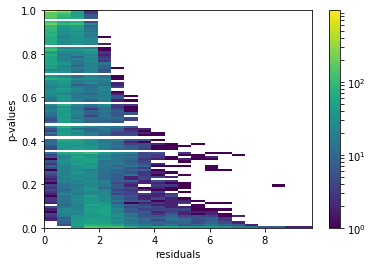

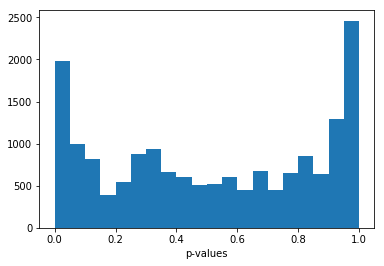

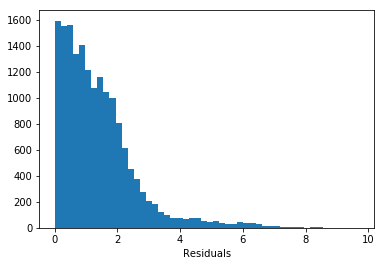

Mean P-value = 0.5172983847109639


In [22]:
if __name__ == '__main__':
	# Main Function
    #tr_frac_range = [50,25,20,15,10,5];
    tr_frac_range=[50];
    #tr_frac=50;
    val_frac = 0.1;
    patience_val = 200;
    num_epochs = 500;
    batch_size = 20;
    #lstm_nodes_range = [4,8,16,25];
    lstm_nodes=8;
    #feedforward_nodes_range = [3,5,7,10];
    feedforward_nodes=5;
    mask_value = 0;
    drop_frac = 0.3;
    #drop_frac_range=[0.2,0.3,0.5];
    lstm_bias = 1;
    #n_nodes_range=[5,10];
    n_nodes=5;
    use_GLM=1;
    use_temporal_feature=1;
    usePad = 0;
    iter_range=np.arange(1);
    lamda_reg=0.05;
    #iter_range=[1];
    #iteration=0;  
    
    for iteration in iter_range:
       for tr_frac in tr_frac_range:
            PGA_LSTM_train_test(
                          iteration,
                          usePad,
                          tr_frac,
                          val_frac,
                          patience_val,
                          num_epochs,
                          batch_size,
                          lstm_nodes,
                          feedforward_nodes,
                          mask_value,
                          drop_frac,
                          lstm_bias,
                          n_nodes,
                          use_GLM,
                          use_temporal_feature,
                          lamda_reg
            )